In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from VecKM_large import VecKM

import warnings
warnings.filterwarnings("ignore")

### Load our example point cloud.

In [2]:
pts = np.loadtxt('Liberty100k.xyz')
print('The shape of pts is (n, 3):', pts.shape)
print('Preprocessing the data... Normalize the points into a unit ball.')
pts = pts - pts.mean(axis=0, keepdims=1)
r = np.linalg.norm(pts, axis=1).max()
pts = pts / r
pts[0] = np.array([0.00622046,0.62610329,0.07458451]) # this will be the specific point we look into later on.
print(pts)

The shape of pts is (n, 3): (100000, 3)
Preprocessing the data... Normalize the points into a unit ball.
[[ 0.00622046  0.62610329  0.07458451]
 [-0.06785286 -0.46164555  0.09950156]
 [ 0.0838672  -0.56487705 -0.12544057]
 ...
 [-0.07780755 -0.05594401  0.10040794]
 [ 0.11728748  0.19354883 -0.15473476]
 [-0.13075289  0.20784576  0.02455094]]


### Visualization of Global Point Cloud

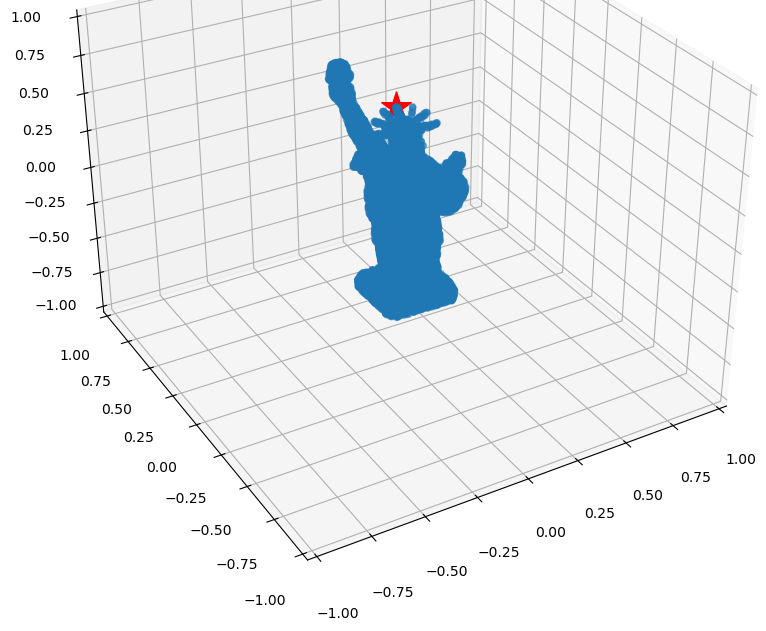

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
rand_index = np.random.permutation(len(pts))[:10000]
ax.scatter(pts[rand_index,0], pts[rand_index,2], pts[rand_index,1], alpha=0.5)
ax.scatter(pts[0,0], pts[0,2], pts[0,1], color='red', marker='*', s=500)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
ax.view_init(30, -120)
ax.set_box_aspect(None, zoom=2)

### Look into the local neighbor of a specific point.

pt_0 has 1012 neighbors with neighborhood radius 0.1.


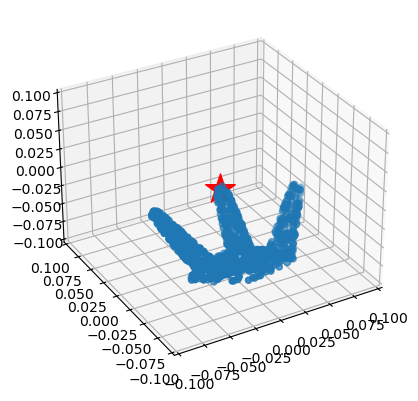

In [4]:
radius = 0.1 # neighborhood radius

dist = np.linalg.norm(pts[0,:] - pts, axis=1)
nbr_idx = dist < radius
nbr_pts = pts[nbr_idx,:]
print(f'pt_0 has {len(nbr_pts)} neighbors with neighborhood radius {radius}.')

# centerize the local neighbor and visualize the local neighbor.
nbr_pts = nbr_pts - pts[0]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nbr_pts[:,0], nbr_pts[:,2], nbr_pts[:,1])
ax.scatter(0,0,0, color='red', marker='*', s=500)
ax.set_xlim3d(-radius, radius)
ax.set_ylim3d(-radius, radius)
ax.set_zlim3d(-radius, radius)
ax.view_init(30, -120)

### Dense Local Geometry Encoding
There are four parameters in VecKM. 
* `alpha`: controlling the resolution of the local geometry encoding.
* `beta_list`: controlling the receptive field of the local geometry encoding. A list of betas is accepted for multi-scaled encoding. The follwing table gives you a reference of what beta to choose depending on your neighborhood radius.
* `d`: the dimension of the encoding. Higher the better, but more expensive as well.
* `p`: for approximating the adjacency matrix. Higher the better, but more expensive as well. Usually small beta requires large p.
<table>
<thead>
  <tr>
    <td>beta</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>4</td>
    <td>5</td>
    <td>6</td>
    <td>7</td>
    <td>8</td>
    <td>9</td>
    <td>10</td>
  </tr>
</thead>
<tbody>
  <tr>
    <td>radius</td>
    <td>1.000</td>
    <td>0.897</td>
    <td>0.598</td>
    <td>0.449</td>
    <td>0.359</td>
    <td>0.299</td>
    <td>0.257</td>
    <td>0.225</td>
    <td>0.200</td>
    <td>0.180</td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>beta</td>
    <td>11</td>
    <td>12</td>
    <td>13</td>
    <td>14</td>
    <td>15</td>
    <td>16</td>
    <td>17</td>
    <td>18</td>
    <td>19</td>
    <td>20</td>
  </tr>
  <tr>
    <td>radius</td>
    <td>0.163</td>
    <td>0.150</td>
    <td>0.138</td>
    <td>0.129</td>
    <td>0.120</td>
    <td>0.113</td>
    <td>0.106</td>
    <td>0.100</td>
    <td>0.095</td>
    <td>0.090</td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>beta</td>
    <td>21</td>
    <td>22</td>
    <td>23</td>
    <td>24</td>
    <td>25</td>
    <td>26</td>
    <td>27</td>
    <td>28</td>
    <td>29</td>
    <td>30</td>
  </tr>
  <tr>
    <td>radius</td>
    <td>0.086</td>
    <td>0.082</td>
    <td>0.078</td>
    <td>0.075</td>
    <td>0.072</td>
    <td>0.069</td>
    <td>0.067</td>
    <td>0.065</td>
    <td>0.062</td>
    <td>0.060</td>
  </tr>
</tbody>
</table>


In [5]:
alpha = [90]
beta_list = [18, 27]
d, p = 1024, 1024

vkm = VecKM(d, alpha, beta_list, p).cuda()
pts = torch.tensor(pts).float().cuda()
print('The input is the point cloud with shape:', pts.shape)
G = vkm(pts)
print(f'The output is the dense geometry encoding with shape {G.shape}.')

The input is the point cloud with shape: torch.Size([100000, 3])
The output is the dense geometry encoding with shape torch.Size([100000, 2, 1024]).


#### Now we look into the geometry computed from beta=18 (radius=0.1 according to the table), by reconstructing the local point cloud distribution from the encoding. In the following code, we study the effect of `d` and `p`.
From the visualization, we can see `d` is more important than `p`. Setting `d=1024`, `p=512` seems to yield a good result.

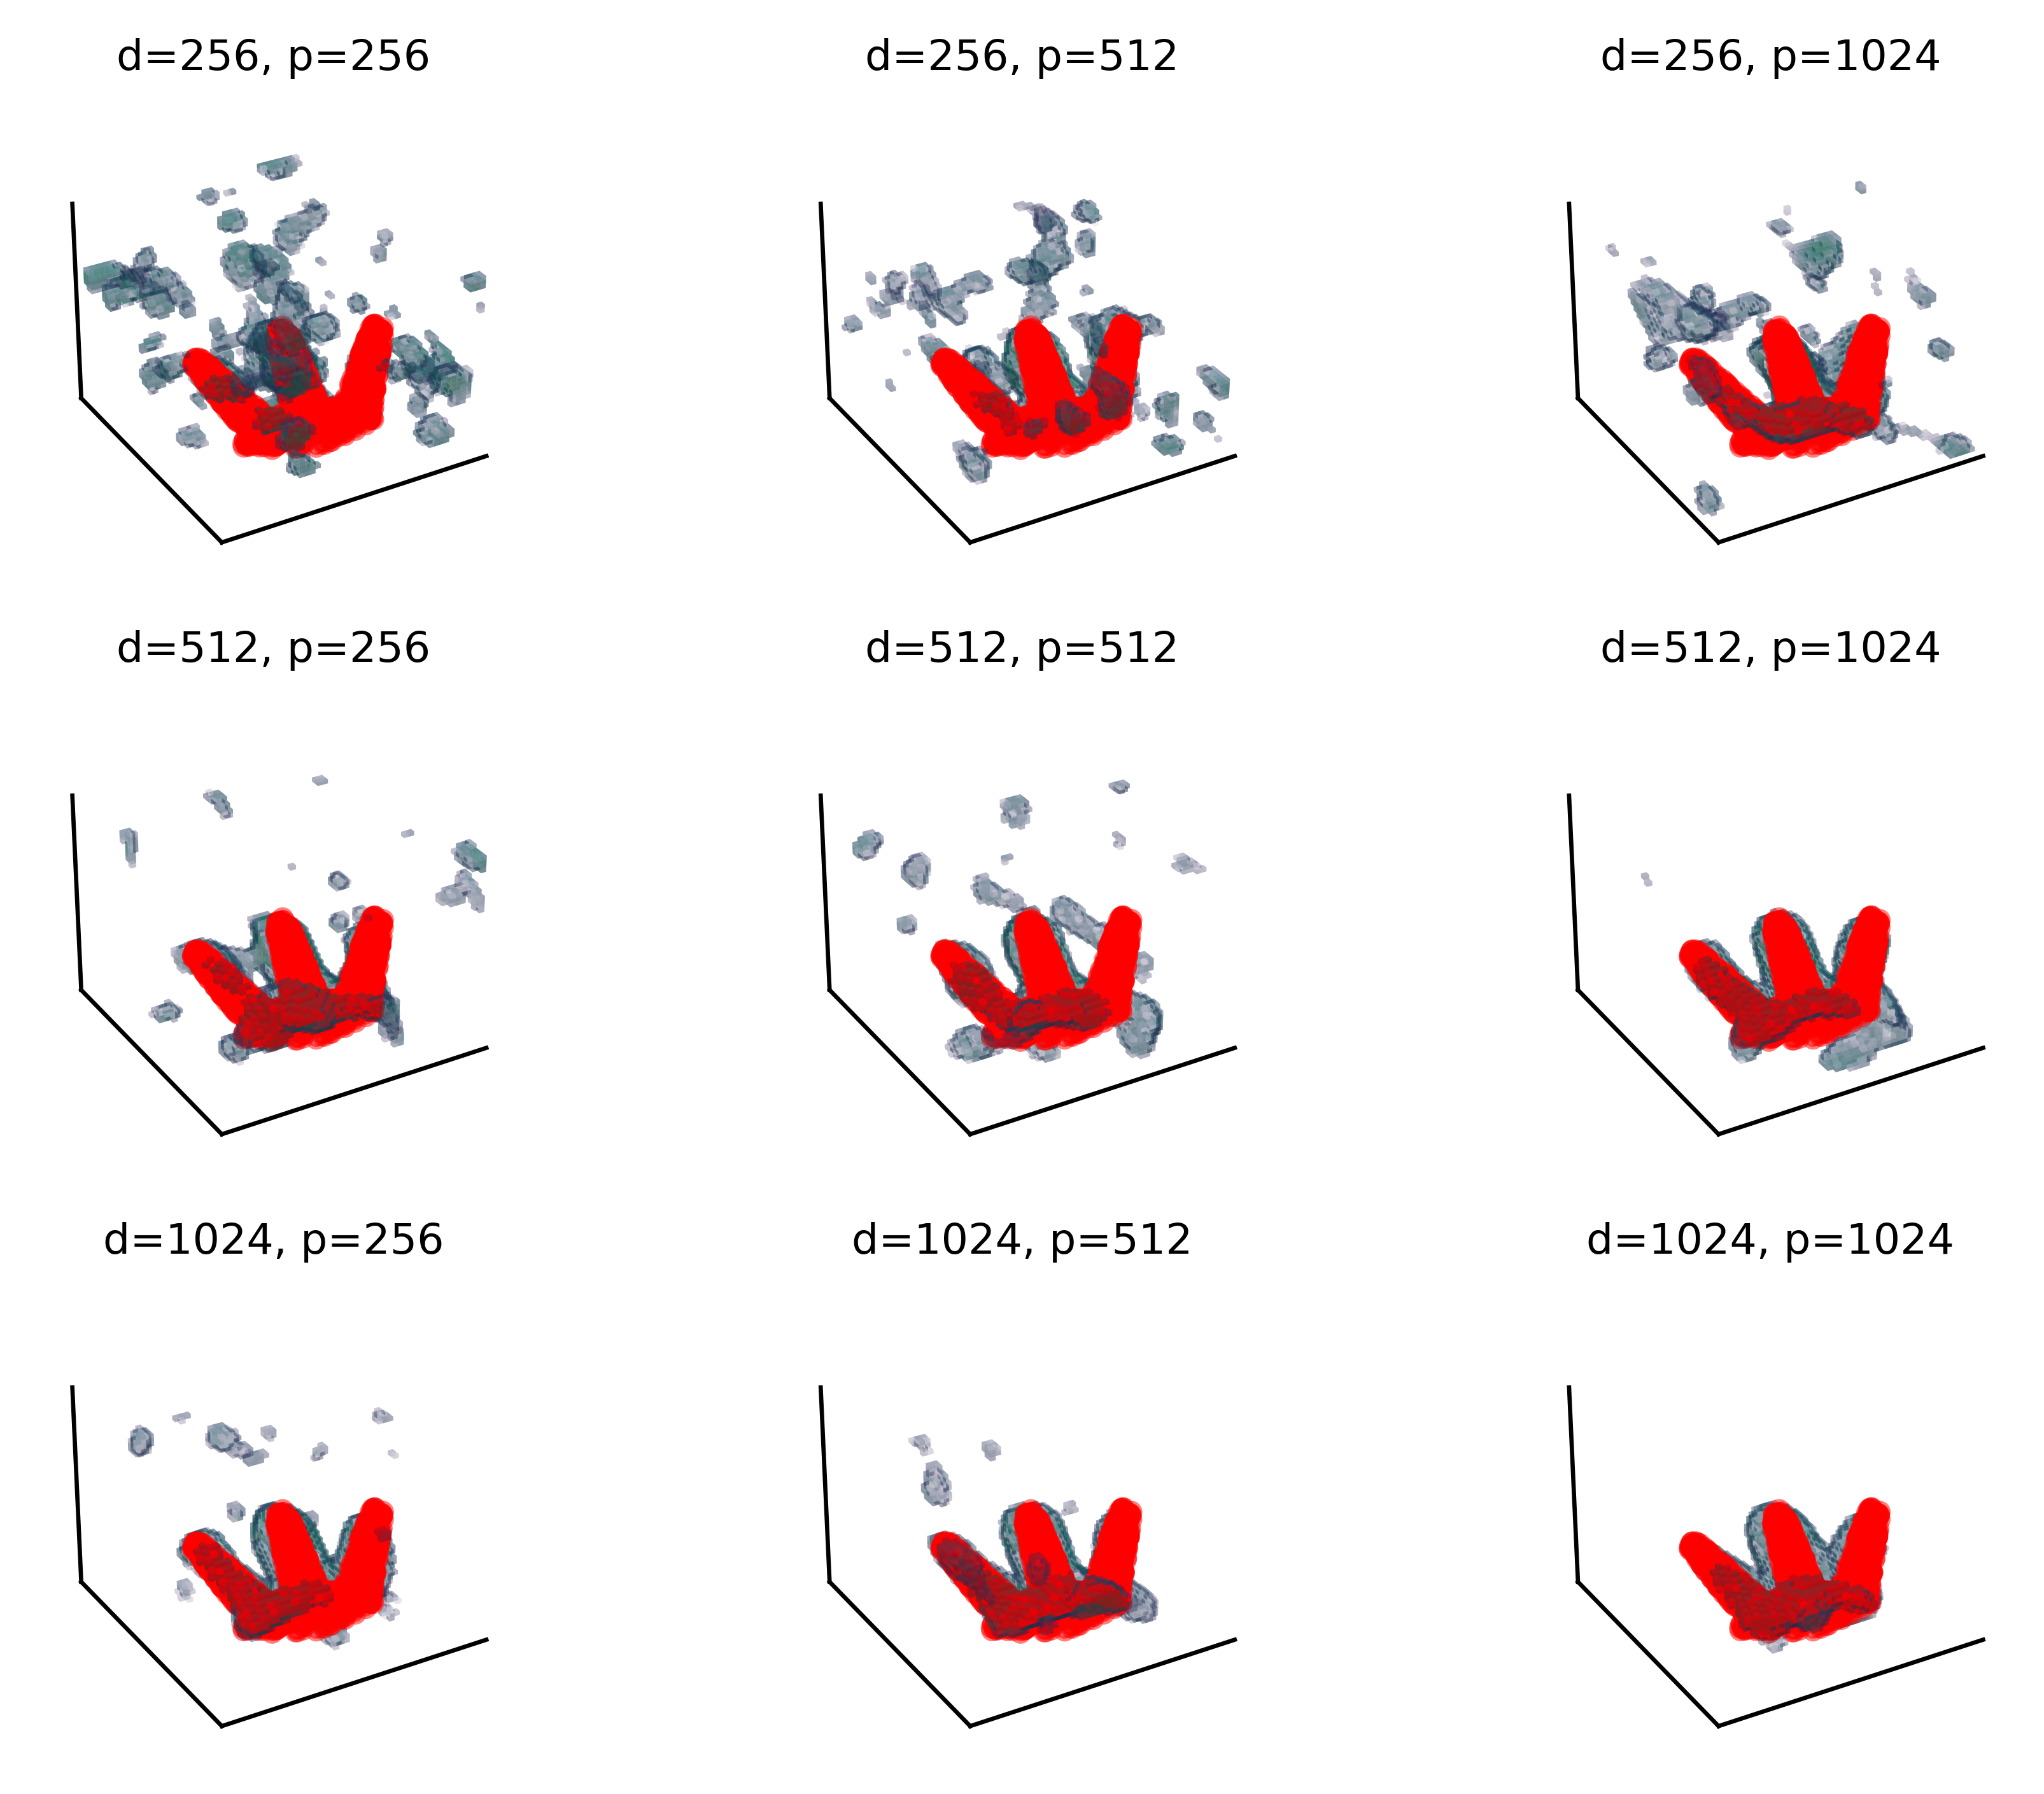

In [7]:
import matplotlib.cm as cm

fig = plt.figure(dpi=600)
total_subplot = 1
for D in [256, 512, 1024]:
    for P in [256, 512, 1024]:
        vkm = VecKM(D, [90], [18], P).cuda()
        G = vkm(pts)
        g = G[0,0,:]
        
        p = np.linspace(-radius, radius, 50)
        xx, yy, zz = np.meshgrid(p, p, p)
        xx_c = (xx[1:,1:,1:] + xx[:-1,:-1,:-1]) / 2
        yy_c = (yy[1:,1:,1:] + yy[:-1,:-1,:-1]) / 2
        zz_c = (zz[1:,1:,1:] + zz[:-1,:-1,:-1]) / 2
        p = np.stack([xx_c.reshape(-1), yy_c.reshape(-1), zz_c.reshape(-1)], axis=1)
        p = torch.from_numpy(p).float().cuda()
        p = torch.exp(1j * (p @ vkm.A))
        score = (p @ g.conj()).abs() / torch.norm(g) / torch.norm(p, dim=1)
        
        thres = torch.sort(score)[0][-5000].item()
        score = score.detach().cpu().numpy()
        score = score.reshape(xx_c.shape)
        score_bool = score > thres
        score = (score - thres) / (score.max() - thres)
        
        colors = np.zeros(score.shape + (4,))
        colors[:,:,:,:3] = cm.viridis(score**0.3)[:,:,:,:3]
        colors[:,:,:,3] = score ** 0.3
        
        ax = fig.add_subplot(3, 3, total_subplot, projection='3d')
        ax.voxels(xx, yy, zz, score_bool, facecolors=colors)
        ax.scatter(nbr_pts[:,0], nbr_pts[:,2], nbr_pts[:,1], s=10, color='red', alpha=0.5)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.set_xlim3d(-radius, radius)
        ax.set_ylim3d(-radius, radius)
        ax.set_zlim3d(-radius, radius)
        ax.grid(False)
        ax.view_init(30, -120)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_title(f'd={D}, p={P}', fontsize=8)

        total_subplot += 1
        
plt.tight_layout()
plt.show()

### Time the VecKM.
The test is done on my personal computer with an **NVIDIA GeForce GTX 1070** GPU with **8GB** memory.

In [1]:
import numpy as np
import torch
import sys
sys.path.append('..')
from VecKM import VecKM

def timing(vkm, pts, repititions=30):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    # GPU warm-up
    for _ in range(10):
        G = vkm(pts)
    # measure performance.
    timings = []
    with torch.no_grad():
        for rep in range(repititions):
            starter.record()
            vkm(pts)
            ender.record()
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings.append(curr_time)
    return np.mean(timings), np.std(timings)

for d in [128, 256, 512, 1024]:
    vkm = VecKM(d, [45], [20], 512).cuda()
    print(f'd={d}')
    for input_size in [1000,5000,10000,50000,100000]:
        pts = torch.randn(input_size, 3).cuda()
        mean_time, std_time = timing(vkm, pts)
        print(f'\tinput_size={input_size}  \t  runtime (ms): {"%.2f"%mean_time} pm {"%.2f"%std_time}.')

d=128
	input_size=1000  	  runtime (ms): 0.61 pm 0.13.
	input_size=5000  	  runtime (ms): 2.27 pm 0.41.
	input_size=10000  	  runtime (ms): 4.11 pm 0.51.
	input_size=50000  	  runtime (ms): 18.62 pm 0.60.
	input_size=100000  	  runtime (ms): 37.52 pm 0.69.
d=256
	input_size=1000  	  runtime (ms): 0.85 pm 0.16.
	input_size=5000  	  runtime (ms): 3.33 pm 0.54.
	input_size=10000  	  runtime (ms): 6.41 pm 0.52.
	input_size=50000  	  runtime (ms): 32.88 pm 0.33.
	input_size=100000  	  runtime (ms): 65.88 pm 0.54.
d=512
	input_size=1000  	  runtime (ms): 1.38 pm 0.26.
	input_size=5000  	  runtime (ms): 6.09 pm 0.54.
	input_size=10000  	  runtime (ms): 12.49 pm 0.65.
	input_size=50000  	  runtime (ms): 62.75 pm 2.16.
	input_size=100000  	  runtime (ms): 126.24 pm 2.46.
d=1024
	input_size=1000  	  runtime (ms): 2.59 pm 0.38.
	input_size=5000  	  runtime (ms): 11.72 pm 0.55.
	input_size=10000  	  runtime (ms): 23.71 pm 0.77.
	input_size=50000  	  runtime (ms): 119.59 pm 2.41.
	input_size=100000